# Análisis de Series Temporales - Trabajo Práctico 1

Integrantes:

* Bermejo, Joaquín
* Scarafía, Franco
* Seward, Gerard

## 1. Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 2. Carga de datasets

In [2]:
df = pd.read_csv('input/viajes_bici.csv')

df_train = df[df['fecha'] < '2024-01-01']
df_test  = df[df['fecha'] >= '2024-01-01']

df_train = df_train.set_index('fecha')
df_test  = df_test.set_index('fecha')

df_train.index = pd.to_datetime(df_train.index, format='%Y-%m-%d')
df_test.index  = pd.to_datetime(df_test.index, format='%Y-%m-%d')

In [100]:
eco_train = df_train[df_train['destino'] == 'Fac. Ciencias Económicas']
eco_test  = df_test[df_test['destino'] == 'Fac. Ciencias Económicas']

med_train = df_train[df_train['destino'] == 'Fac. Medicina']
med_test  = df_test[df_test['destino'] == 'Fac. Medicina']

ing_train = df_train[df_train['destino'] == 'Fac. de Ingeniería']
ing_test  = df_test[df_test['destino'] == 'Fac. de Ingeniería']

## 3. Funciones auxiliares

In [8]:
# Imputar ceros por la media
# eco_train['viajes'] = eco_train['viajes'].replace(0, eco_train['viajes'].mean())

In [7]:
# Evaluar graficamente que transformacion aplicar para estabilizar la variancia
# avg = eco_train.groupby([pd.Grouper(key='fecha', freq='W-MON')])['viajes'].mean().reset_index().sort_values('fecha').viajes
# sd = eco_train.groupby([pd.Grouper(key='fecha', freq='W-MON')])['viajes'].std().reset_index().sort_values('fecha').viajes
# plt.scatter(avg, sd)

In [36]:
# Intento de aplicar transformaciones para corregir la heterocedasticidad (no funcionaron)
# eco_train['viajes_modif'] = np.sqrt(eco_train.viajes.values + 3/8)
# eco_train['viajes_modif'] = np.log(eco_train.viajes.values)

In [5]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Rechazar la hipótesis nula")
    print("Los datos son estacionarios.")
  else:
    print("Conclusion:====>")
    print("No rechazar la hipótesis nula")
    print("Los datos no son estacionarios.")

In [4]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'): # [3]
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Gráfico de analisys de Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [5]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE:  {round(mean_squared_error(serie_test, serie_pred),2)}')
    print(f'MAE:  {round(mean_absolute_error(serie_test, serie_pred),2)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(serie_test, serie_pred)),2)}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [62]:
def pronosticos_simples(train, test):
    forecasts = {}
    
    # Average
    forecasts['avg'] = len(test)*[train['viajes'].sum() / len(train)]
    
    # Naive
    forecasts['naive'] = len(test)*[train['viajes'][-1]]
    
    # Naive estacional
    forecasts['naive_s'] = np.tile(train['viajes'].iloc[-7:].values, int(np.ceil(len(test) / 7)))[:len(test)]
    
    # Drift
    m = (train.iloc[-1]['viajes'] - train.iloc[0]['viajes']) / len(train)
    h = np.linspace(0, len(test)-1, len(test))
    forecasts['drift'] = train.iloc[-1]['viajes'] + m * h

    metrics = []
    fmethods = ['avg', 'drift', 'naive', 'naive_s']
    
    for fmethod in fmethods:
        metrics.append([
            round(mean_squared_error(test['viajes'], forecasts[fmethod]), 2),
            round(mean_absolute_error(test['viajes'], forecasts[fmethod]), 2),
            round(np.sqrt(mean_squared_error(test['viajes'], forecasts[fmethod])), 2),
            round(np.mean(abs((test['viajes']-forecasts[fmethod])/test['viajes'])), 4)
        ])

    metrics_df = pd.DataFrame(metrics, index=fmethods, columns=['MSE', 'MAE', 'RMSE', 'MAPE'])
    print(metrics_df)

## 4. Análisis (individual) de series

### 4.a. Fac. Ciencias Económicas

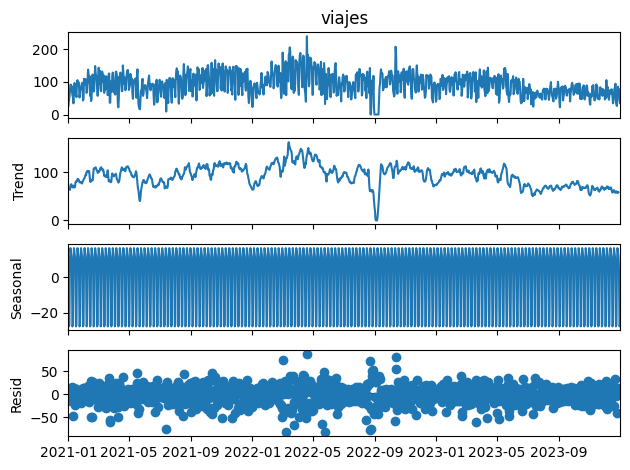

In [40]:
result = seasonal_decompose(eco_train['viajes'], model="additive")
result.plot();

Se detecta un componente estacional de período 7 (semanal).

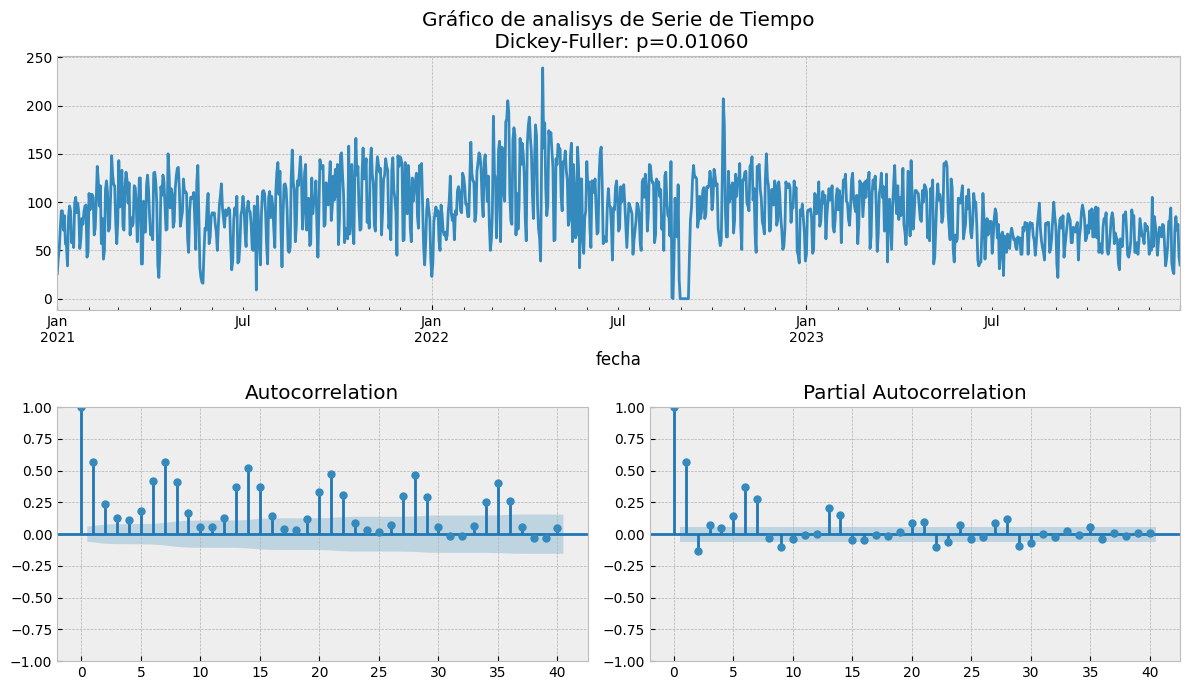

In [41]:
tsplot(eco_train['viajes'], lags = 40);

Observaciones:

* Una estacionalidad semestral en la serie, con máximos a mitad de cada semestre y mínimos en los extremos.
* Un p-value significativo del test de raíces unitarias.
* Una recurrencia de picos en la función de autocorrelación, cada 7 lags.
* Un decaimiento veloz de los primeros lags en la función de autocorrelación.
* Un decaimiento lento de la autocorrelación en los picos estacionales.
* En los lags regulares de la FACP, sólo el primer lag toma un valor significativo.
* En los lags estacionales de la FACP, los lags $7k-1$ y $7k$ son significativos y positivos.

Conclusiones (a partir de lo observado):

* Estacionariedad en la parte regular.
* Presencia de un doble componente estacional: uno con frecuencia semanal y otro con frecuencia semestral (no pueden modelarse en conjunto).
* La parte regular podría ser un $AR(1)$ o similar.
* Quizás haya que aplicar una diferenciación estacional.
* La parte estacional podría ser un $ARMA(1,1)$ o similar.

Se procede entonces a aplicar una **diferenciación estacional** y evaluar el resultado.

In [109]:
ecoD1 = eco_train.viajes.values[7:] - eco_train.viajes.values[:-7]
ecoD1 = np.concatenate([ecoD1, 7*[0]])
eco_train['viajes_D1'] = ecoD1

C:\Users\PC\AppData\Local\Temp\ipykernel_18256\2522106940.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_train['viajes_D1'] = ecoD1


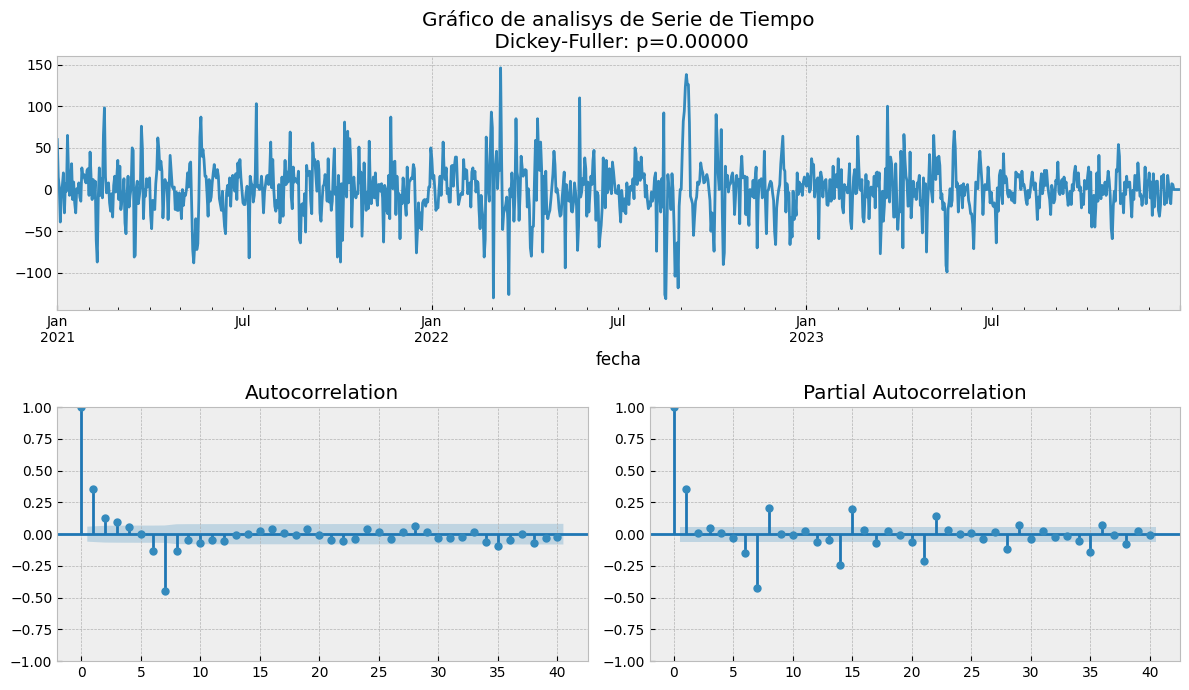

In [43]:
tsplot(eco_train['viajes_D1'], lags = 40);

Observaciones:

* La diferenciación estacional parece haber simplificado el comportamiento de la FAC.
* En la FAC, la parte regular decae velozmente y en la parte estacional sólo un lag (el 7) resulta significativo.
* En la FACP, la parte regular sólo muestra un lag significativo, mientras que la parte estacional muestra múltiples pares adyacentes de lags significativos.

Conclusiones (a partir de lo observado):

* La parte regular podría ser un $AR(1)$ o similar.
* La parte estacional podría ser un $ARMA(1,1)$ o similar.

#### Modelo A: simple y con diferenciación estacional

In [44]:
model_eco = auto_arima(
    eco_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=1,
    max_p=2, max_q=2,
    max_P=2, max_Q=2,
    test='adf', with_intercept=False,
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=10195.403, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=10610.289, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=10191.345, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=9990.961, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=10608.291, Time=0.00 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=10481.370, Time=0.11 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=9983.746, Time=0.36 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=10216.175, Time=0.22 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=9980.329, Time=1.49 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=10126.379, Time=0.41 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=9982.770, Time=1.46 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=10183.415, Time=1.01 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,0,2)(2,1,1)[7] intercept  

In [7]:
modA_eco = SARIMAX(eco_train['viajes'], order=(1, 0, 1), seasonal_order=(2, 1, 2, 7))
resA_eco = modA_eco.fit()
predA_eco = resA_eco.get_forecast(steps=121)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [18]:
print("Métricas de performance del pronóstico")
print("AIC: ", round(resA_eco.aic, 1))
print("------------")
evaluar_metricas(eco_test['viajes'], predA_eco.predicted_mean)

Métricas de performance del pronóstico
AIC:  9903.0
------------
MSE:  334.29
MAE:  14.19
RMSE: 18.28
MAPE: 0.3491


En su capacidad predictiva, el modelo A presenta un error absoluto medio de 14 viajes.

Los pronósticos difieren en un 35% de los valores observados.

#### Modelo B: simple y sin diferenciación estacional

In [10]:
model_eco = auto_arima(
    eco_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=0,
    max_p=2, max_q=2,
    max_P=2, max_Q=2,
    test='adf', with_intercept=False,
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=10256.393, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=10850.941, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=10198.536, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=10320.458, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13152.836, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=10422.313, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=10108.431, Time=1.02 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=10064.209, Time=1.53 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=9988.191, Time=0.75 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=10287.154, Time=0.28 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=10040.282, Time=1.24 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=10218.238, Time=0.53 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=10045.243, Time=0.94 sec
 ARIMA(1,0,1)(1,0,1)[7] in

In [19]:
modB_eco = SARIMAX(eco_train['viajes'], order=(1, 0, 1), seasonal_order=(2, 0, 1, 7))
resB_eco = modB_eco.fit()
predB_eco = resB_eco.get_forecast(steps=121)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [20]:
print("Métricas de performance del pronóstico")
print("AIC: ", round(resB_eco.aic, 1))
print("------------")
evaluar_metricas(eco_test['viajes'], predB_eco.predicted_mean)

Métricas de performance del pronóstico
AIC:  9974.9
------------
MSE:  282.99
MAE:  12.64
RMSE: 16.82
MAPE: 0.3146


En su capacidad predictiva, el modelo B presenta un error absoluto medio de 13 viajes.

Los pronósticos difieren en un 31% de los valores observados.

#### Modelo C: complejo y con diferenciación estacional

In [22]:
model_eco = auto_arima(
    eco_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=1,
    max_p=7, max_q=7,
    max_P=7, max_Q=7,
    test='adf', with_intercept=False,
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7]             : AIC=10194.331, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=10608.291, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=10189.346, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=9989.551, Time=0.15 sec
 ARIMA(0,0,1)(0,1,0)[7]             : AIC=10479.369, Time=0.05 sec
 ARIMA(0,0,1)(1,1,1)[7]             : AIC=9982.939, Time=0.23 sec
 ARIMA(0,0,1)(1,1,0)[7]             : AIC=10214.178, Time=0.09 sec
 ARIMA(0,0,1)(2,1,1)[7]             : AIC=9979.905, Time=0.85 sec
 ARIMA(0,0,1)(2,1,0)[7]             : AIC=10124.388, Time=0.17 sec
 ARIMA(0,0,1)(3,1,1)[7]             : AIC=9979.962, Time=1.31 sec
 ARIMA(0,0,1)(2,1,2)[7]             : AIC=9982.107, Time=1.18 sec
 ARIMA(0,0,1)(1,1,2)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(0,0,1)(3,1,0)[7]             : AIC=10064.700, Time=0.35 sec
 ARIMA(0,0,1)(3,1,2)[7]             : AIC=9982.626, Time=2.34 sec
 ARIMA(0,0,0)(2,1,1)[7]        

In [23]:
modC_eco = SARIMAX(eco_train['viajes'], order=(0, 0, 5), seasonal_order=(2, 1, 2, 7))
resC_eco = modC_eco.fit()
predC_eco = resC_eco.get_forecast(steps=121)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [25]:
print("Métricas de performance del pronóstico")
print("AIC: ", round(resC_eco.aic, 1))
print("------------")
evaluar_metricas(eco_test['viajes'], predC_eco.predicted_mean)

Métricas de performance del pronóstico
AIC:  9917.8
------------
MSE:  313.41
MAE:  13.6
RMSE: 17.7
MAPE: 0.3355


En su capacidad predictiva, el modelo C presenta un error absoluto medio de 14 viajes.

Los pronósticos difieren en un 34% de los valores observados.

#### Modelo D: complejo y sin diferenciación estacional

In [26]:
model_eco = auto_arima(
    eco_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=0,
    max_p=7, max_q=7,
    max_P=7, max_Q=7,
    test='adf', with_intercept=False,
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7]             : AIC=10285.339, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13152.836, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7]             : AIC=10472.161, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[7]             : AIC=11534.037, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[7]             : AIC=12239.618, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[7]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(2,0,1)[7]             : AIC=10276.408, Time=0.26 sec
 ARIMA(0,0,0)(2,0,0)[7]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(3,0,1)[7]             : AIC=10265.893, Time=0.89 sec
 ARIMA(0,0,0)(3,0,0)[7]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(4,0,1)[7]             : AIC=10265.472, Time=1.44 sec
 ARIMA(0,0,0)(4,0,0)[7]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(5,0,1)[7]             : AIC=inf, Time=4.47 sec
 ARIMA(0,0,0)(4,0,2)[7]             : AIC=inf, Time=1.50 sec
 ARIMA(0,0,0)(3,0,2)[7]             : AIC=10270.881, Ti

In [27]:
modD_eco = SARIMAX(eco_train['viajes'], order=(1, 0, 0), seasonal_order=(7, 0, 1, 7))
resD_eco = modD_eco.fit()
predD_eco = resD_eco.get_forecast(steps=121)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
print("Métricas de performance del pronóstico")
print("AIC: ", round(resD_eco.aic, 1))
print("------------")
evaluar_metricas(eco_test['viajes'], predD_eco.predicted_mean)

Métricas de performance del pronóstico
AIC:  9991.0
------------
MSE:  260.41
MAE:  12.04
RMSE: 16.14
MAPE: 0.2974


En su capacidad predictiva, el modelo D presenta un error absoluto medio de 12 viajes.

Los pronósticos difieren en un 30% de los valores observados.

Se elige el **modelo B (simple y sin diferenciación estacional)** como modelo final.

Si bien no es el que posee mejores métricas de pronóstico, logra un muy buen balance entre parsimonia y capacidad predictiva.

#### Pronósticos sin modelos

In [41]:
pronosticos_simples(eco_train, eco_test)

             MSE    MAE   RMSE    MAPE
avg      1440.67  34.07  37.96  0.8082
drift     792.75  24.15  28.16  0.3990
naive     814.05  24.53  28.53  0.4039
naive_s   443.20  16.09  21.05  0.3269


C:\Users\PC\AppData\Local\Temp\ipykernel_6636\1242341496.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts['naive'] = len(test)*[train['viajes'][-1]]


Ninguno de estos pronósticos supera al modelo seleccionado, aunque el naive estacional está cerca en algunas métricas.

#### Pronóstico del modelo seleccionado

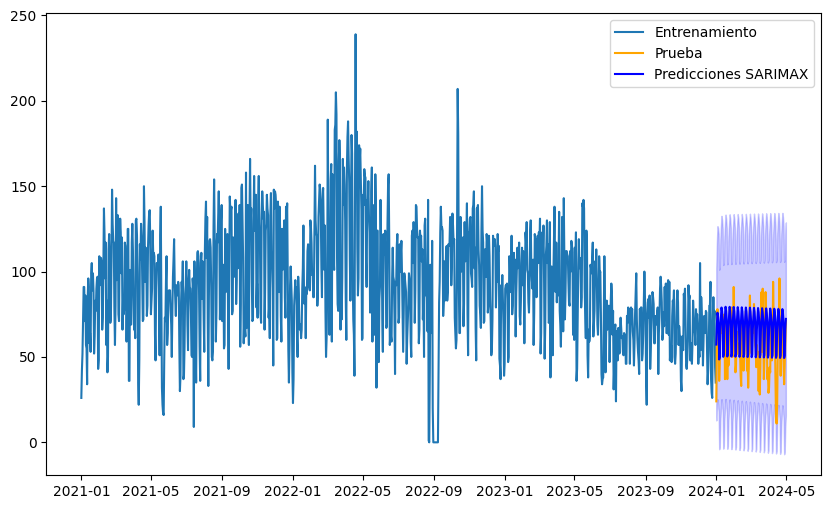

In [29]:
# Predicciones del modelo
pred_eco = resB_eco.get_forecast(steps=121)
pred_ci_eco = predB_eco.conf_int()


plt.figure(figsize=(10, 6))
plt.plot(eco_train.index, eco_train['viajes'], label='Entrenamiento')
plt.plot(eco_test.index, eco_test['viajes'], label='Prueba', color='orange')
plt.plot(eco_test.index, pred_eco.predicted_mean, label='Predicciones SARIMAX', color='blue')
plt.fill_between(eco_test.index, pred_ci_eco.iloc[:, 0], pred_ci_eco.iloc[:, 1], color='blue', alpha=0.2)
plt.legend()
plt.show()

#### Evaluación de supuestos

In [30]:
resB_eco.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            viajes   No. Observations:                 1095
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -4981.467
Date:                           Wed, 25 Dec 2024   AIC                           9974.933
Time:                                   12:13:48   BIC                          10004.924
Sample:                               01-01-2021   HQIC                          9986.282
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7265      0.032     22.884      0.000       0.664       0.789
ma.L1         -0.2829      0.040     -7.061      0.000      -0.361      -0.204
ar.S.L7        1.0507      0.023     44.893      0.000       1.005       1.097
ar.S.L14      -0.0519      0.023     -2.239      0.025      -0.097      -0.006
ma.S.L7       -0.9271      0.013    -71.035      0.000      -0.953      -0.901
sigma2       514.3131     13.995     36.750      0.000     486.884     541.742
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):               654.50
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

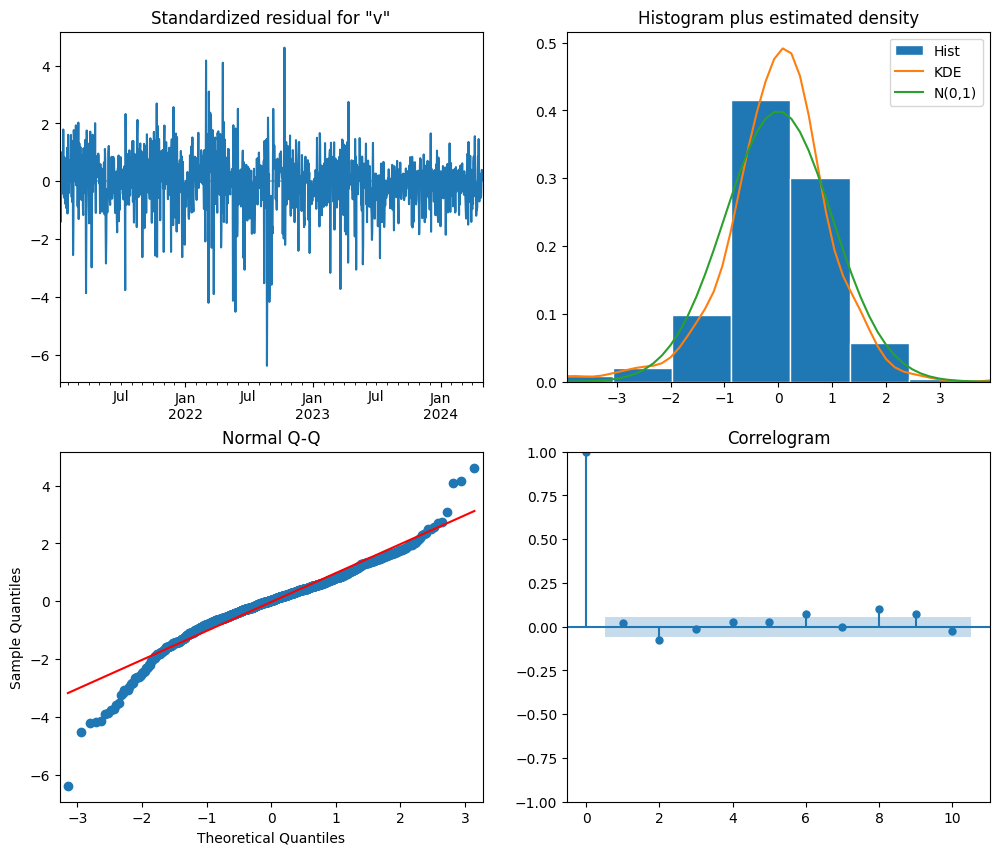

In [27]:
fig_res_eco = resultado_eco.plot_diagnostics(figsize=(12,10))

* **Ljung-Box:** los residuos no exhiben correlación serial ($p=0.34$).
    * Se cumple el supuesto de incorrelación de los residuos.
* **Jarque-Bera:** los residuos no siguen una distibución Normal ($p<0.01$).
    * No se cumple el supuesto de Normalidad de los residuos.
* **Heterocedasticidad:** los residuos tienen varianza variable en el tiempo ($p < 0.01$).
    * No se cumple el supuesto de homocedasticidad.

### 4.b. Fac. Medicina

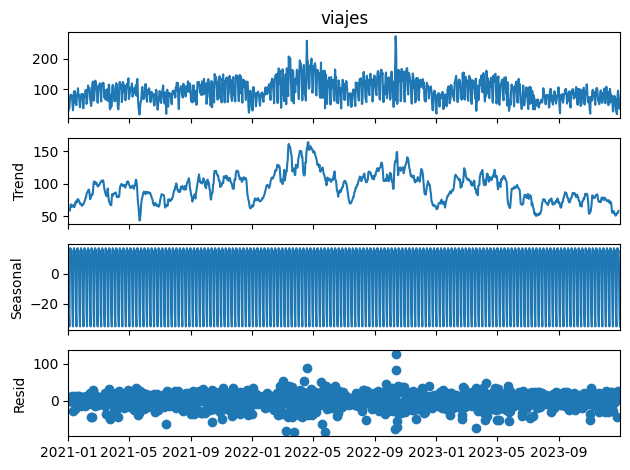

In [32]:
result = seasonal_decompose(med_train['viajes'], model="additive")
result.plot();

Se detecta un componente estacional de período 7 (semanal).

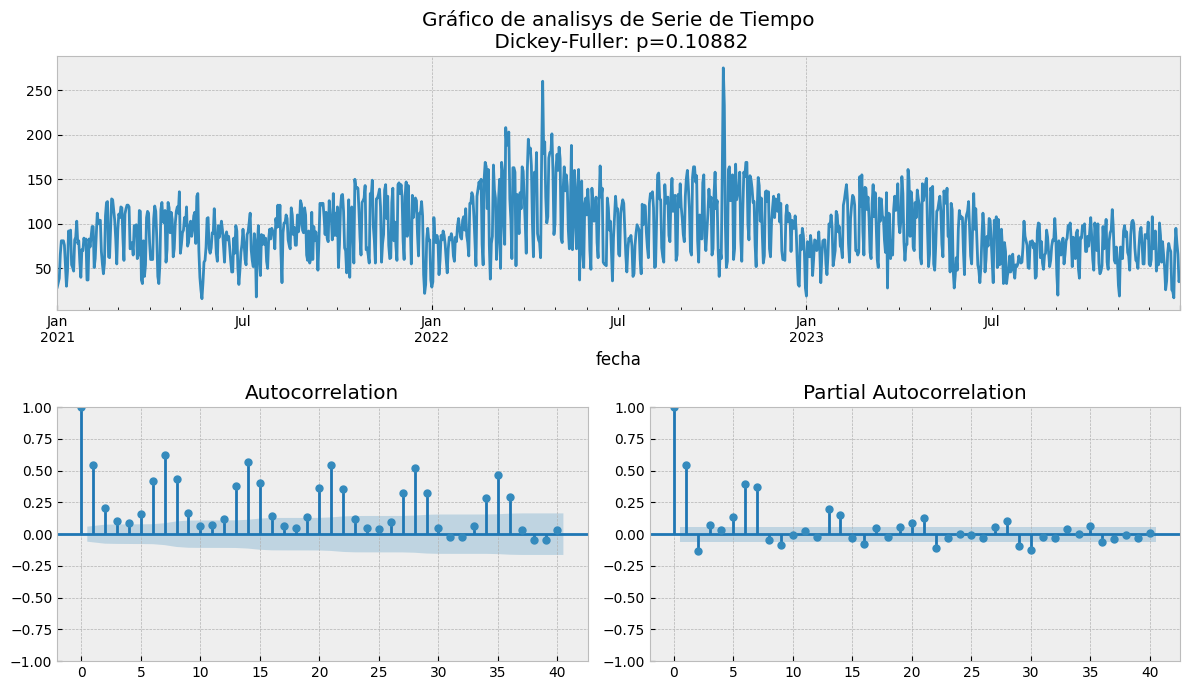

In [33]:
tsplot(med_train['viajes'], lags = 40);

El test de raíces unitarias arroja un p-value elevado, por lo que habría que diferenciar la serie para transformarla en estacionaria.

Se podría probar qué tipo de diferenciación es más conveniente: una regular o una estacional, si bien este test refiere a raíces unitarias regulares.

In [101]:
med_diff = med_train.viajes.values[1:] - med_train.viajes.values[:-1]
med_diff = np.concatenate([med_diff, [0]])
med_train['viajes_diff'] = med_diff

C:\Users\PC\AppData\Local\Temp\ipykernel_18256\2258229719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_train['viajes_diff'] = med_diff


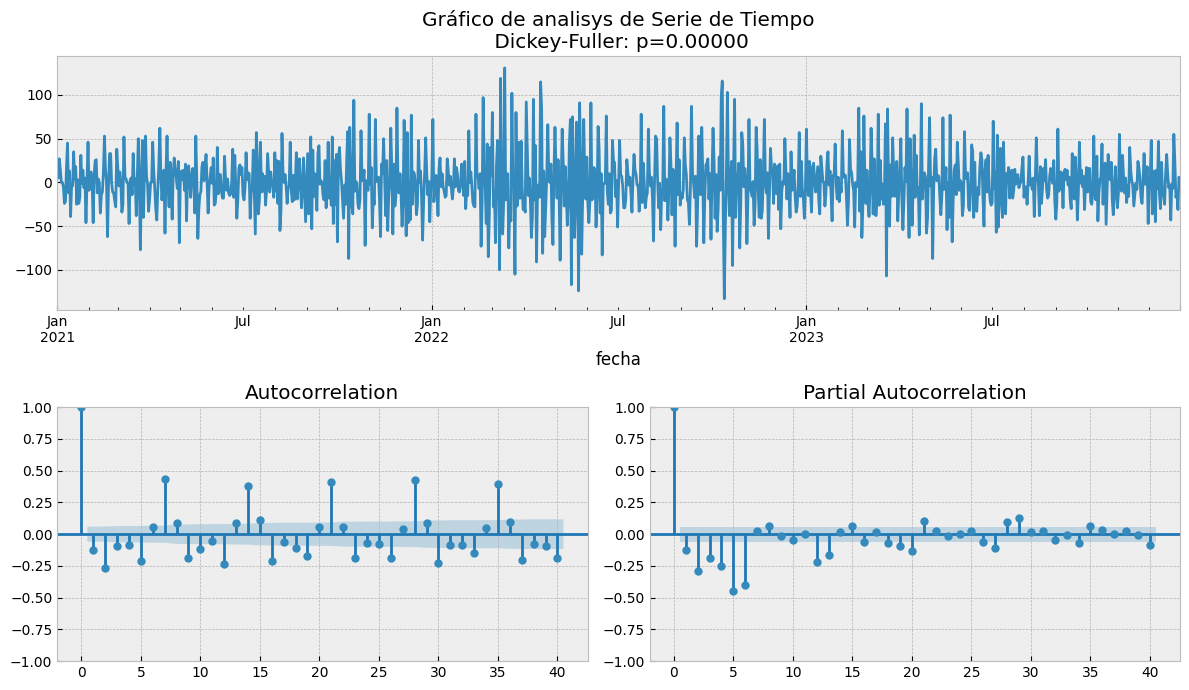

In [102]:
tsplot(med_train['viajes_diff'], lags = 40);

Si bien el test de raíces unitarias ya no señala una necesidad de diferenciar, la FAC muestra que los lags $7k$ no decrecen.

Podría considerarse, entonces, aplicar una diferenciación estacional en lugar de una regular.

In [103]:
medD1 = med_train.viajes.values[7:] - med_train.viajes.values[:-7]
medD1 = np.concatenate([medD1, 7*[0]])
med_train['viajes_D1'] = medD1

C:\Users\PC\AppData\Local\Temp\ipykernel_18256\993268023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_train['viajes_D1'] = medD1


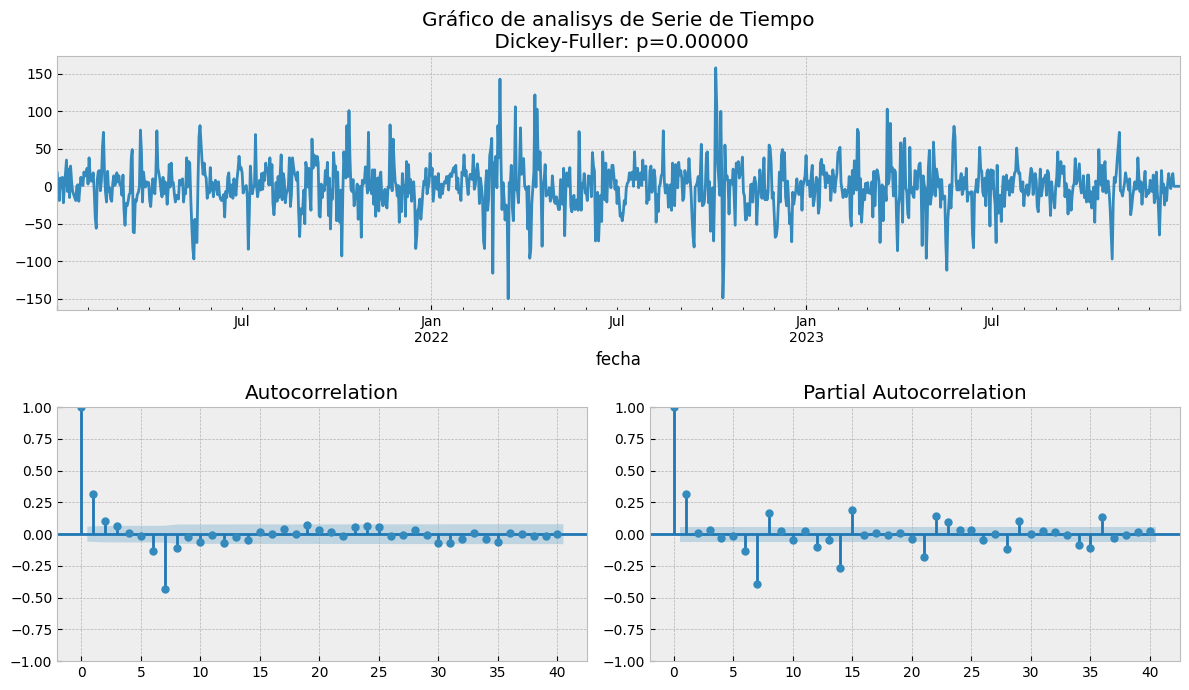

In [37]:
tsplot(med_train['viajes_D1'], lags = 40);

Ahora el test de raíces unitarias indica estacionariedad, y la FAC parece mostrar una convergencia de las correlaciones.

La FAC y la FACP se muestran muy similares a la serie de la Fac. de Ciencias Económicas, por lo que podrían trazarse las mismas conclusiones.

Visto que la diferenciación estacional es estrictamente necesaria para esta serie, se propondrán sólo dos modelos:

* **Modelo A:** simple y con diferenciación estacional
* **Modelo B:** complejo y con diferenciación estacional

#### Modelo A: simple y con diferenciación estacional

In [38]:
model_med = auto_arima(
    med_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=1,
    max_p=2, max_q=2,
    max_P=2, max_Q=2,
    test='adf', with_intercept=False,
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7]             : AIC=10163.882, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=10543.127, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=10200.491, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=10004.231, Time=0.17 sec
 ARIMA(0,0,1)(0,1,0)[7]             : AIC=10442.238, Time=0.04 sec
 ARIMA(0,0,1)(1,1,1)[7]             : AIC=9993.280, Time=0.28 sec
 ARIMA(0,0,1)(1,1,0)[7]             : AIC=10217.049, Time=0.08 sec
 ARIMA(0,0,1)(2,1,1)[7]             : AIC=9993.481, Time=0.84 sec
 ARIMA(0,0,1)(1,1,2)[7]             : AIC=inf, Time=1.05 sec
 ARIMA(0,0,1)(0,1,2)[7]             : AIC=9994.633, Time=0.42 sec
 ARIMA(0,0,1)(2,1,0)[7]             : AIC=10104.245, Time=0.17 sec
 ARIMA(0,0,1)(2,1,2)[7]             : AIC=9996.701, Time=1.22 sec
 ARIMA(1,0,1)(1,1,1)[7]             : AIC=9920.449, Time=0.54 sec
 ARIMA(1,0,1)(0,1,1)[7]             : AIC=9925.569, Time=0.32 sec
 ARIMA(1,0,1)(1,1,0)[7]        

In [39]:
modA_med = SARIMAX(med_train['viajes'], order=(1, 0, 1), seasonal_order=(0, 1, 2, 7))
resA_med = modA_med.fit()
predA_med = resA_med.get_forecast(steps=121)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [40]:
print("Métricas de performance del pronóstico")
print("AIC: ", round(resA_med.aic, 1))
print("------------")
evaluar_metricas(med_test['viajes'], predA_med.predicted_mean)

Métricas de performance del pronóstico
AIC:  9920.4
------------
MSE:  361.33
MAE:  14.31
RMSE: 19.01
MAPE: 0.3074


En su capacidad predictiva, el modelo A presenta un error absoluto medio de 14 viajes.

Los pronósticos difieren en un 31% de los valores observados.

#### Modelo B: complejo y con diferenciación estacional

In [41]:
model_med = auto_arima(
    med_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=1,
    max_p=7, max_q=7,
    max_P=7, max_Q=7,
    test='adf', with_intercept=False,
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7]             : AIC=10163.882, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=10543.127, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=10200.491, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=10004.231, Time=0.17 sec
 ARIMA(0,0,1)(0,1,0)[7]             : AIC=10442.238, Time=0.04 sec
 ARIMA(0,0,1)(1,1,1)[7]             : AIC=9993.280, Time=0.28 sec
 ARIMA(0,0,1)(1,1,0)[7]             : AIC=10217.049, Time=0.08 sec
 ARIMA(0,0,1)(2,1,1)[7]             : AIC=9993.481, Time=0.74 sec
 ARIMA(0,0,1)(1,1,2)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(0,0,1)(0,1,2)[7]             : AIC=9994.633, Time=0.43 sec
 ARIMA(0,0,1)(2,1,0)[7]             : AIC=10104.245, Time=0.18 sec
 ARIMA(0,0,1)(2,1,2)[7]             : AIC=9996.701, Time=1.24 sec
 ARIMA(1,0,1)(1,1,1)[7]             : AIC=9920.449, Time=0.53 sec
 ARIMA(1,0,1)(0,1,1)[7]             : AIC=9925.569, Time=0.33 sec
 ARIMA(1,0,1)(1,1,0)[7]        

El modelo B es igual al modelo A.

Con el fin de tener múltiples modelos para comparar, se propone un modelo C que sea simple y sin diferenciación (si bien sabemos que es necesaria).

#### Modelo C: simple y sin diferenciación estacional

In [42]:
model_med = auto_arima(
    med_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=0,
    max_p=2, max_q=2,
    max_P=2, max_Q=2,
    test='adf', with_intercept=False,
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7]             : AIC=10248.462, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13191.769, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7]             : AIC=10459.151, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[7]             : AIC=11521.666, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[7]             : AIC=12234.049, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[7]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(2,0,1)[7]             : AIC=10245.112, Time=0.22 sec
 ARIMA(0,0,0)(2,0,0)[7]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(2,0,2)[7]             : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(1,0,2)[7]             : AIC=10245.797, Time=0.23 sec
 ARIMA(1,0,0)(2,0,1)[7]             : AIC=10010.851, Time=0.62 sec
 ARIMA(1,0,0)(1,0,1)[7]             : AIC=10018.397, Time=0.26 sec
 ARIMA(1,0,0)(2,0,0)[7]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(2,0,2)[7]             : AIC=inf, Time=1.14 sec
 ARIMA(1,0,0)(1,0,2)[7]             : AIC=10011.0

In [43]:
modC_med = SARIMAX(med_train['viajes'], order=(1, 0, 1), seasonal_order=(1, 0, 2, 7))
resC_med = modC_med.fit()
predC_med = resC_med.get_forecast(steps=121)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [44]:
print("Métricas de performance del pronóstico")
print("AIC: ", round(resC_med.aic, 1))
print("------------")
evaluar_metricas(med_test['viajes'], predC_med.predicted_mean)

Métricas de performance del pronóstico
AIC:  9991.4
------------
MSE:  336.76
MAE:  13.67
RMSE: 18.35
MAPE: 0.2881


En su capacidad predictiva, el modelo C presenta un error absoluto medio de 14 viajes.

Los pronósticos difieren en un 29% de los valores observados.

Si bien el modelo C presenta una mayor capacidad predictiva, la mejora no es lo suficientemente sustancial como para descartar la diferenciación.

Además, sabemos que la estacionariedad es necesaria para el cumplimiento de los supuestos asociados al modelo.

In [63]:
pronosticos_simples(med_train, med_test)

             MSE    MAE   RMSE    MAPE
avg      1278.80  30.05  35.76  0.6902
drift    1112.18  27.87  33.35  0.4012
naive    1131.54  28.13  33.64  0.4039
naive_s   817.77  20.33  28.60  0.3274


C:\Users\PC\AppData\Local\Temp\ipykernel_18256\3463645638.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts['naive'] = len(test)*[train['viajes'][-1]]


Los pronósticos simples no presentan una mayor capacidad predictiva que el modelo propuesto.

#### Pronóstico del modelo seleccionado

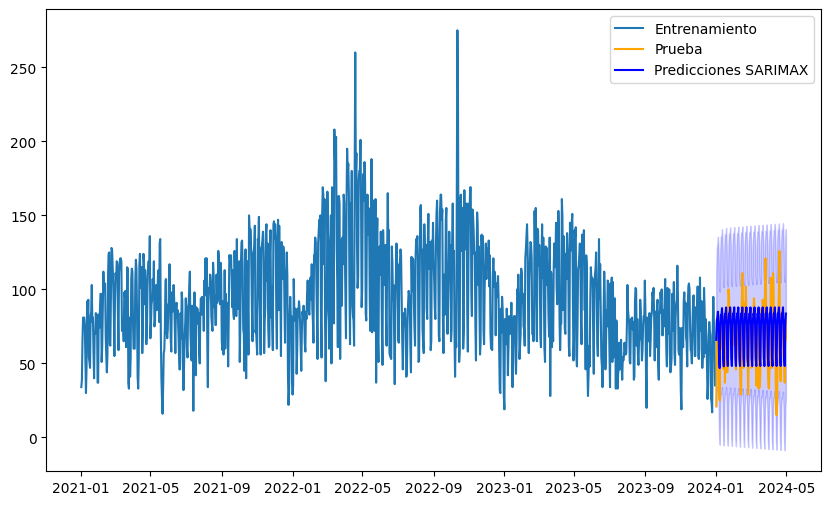

In [66]:
# Predicciones del modelo
pred_med = resA_med.get_forecast(steps=121)
pred_ci_med = predA_med.conf_int()


plt.figure(figsize=(10, 6))
plt.plot(med_train.index, med_train['viajes'], label='Entrenamiento')
plt.plot(med_test.index, med_test['viajes'], label='Prueba', color='orange')
plt.plot(med_test.index, pred_med.predicted_mean, label='Predicciones SARIMAX', color='blue')
plt.fill_between(med_test.index, pred_ci_med.iloc[:, 0], pred_ci_med.iloc[:, 1], color='blue', alpha=0.2)
plt.legend()
plt.show()

In [48]:
resA_med.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                 viajes   No. Observations:                 1094
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -4955.214
Date:                                Wed, 25 Dec 2024   AIC                           9920.428
Time:                                        12:38:17   BIC                           9945.384
Sample:                                    01-02-2021   HQIC                          9929.875
                                         - 12-31-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7585      0.035     21.460      0.000       0.689       0.828
ma.L1         -0.3832      0.044     -8.657      0.000      -0.470      -0.296
ma.S.L7       -0.8292      0.025    -33.601      0.000      -0.878      -0.781
ma.S.L14      -0.0839      0.024     -3.432      0.001      -0.132      -0.036
sigma2       527.5128     14.127     37.340      0.000     499.824     555.202
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):               585.21
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.20
Prob(H) (two-sided):                  0.75   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

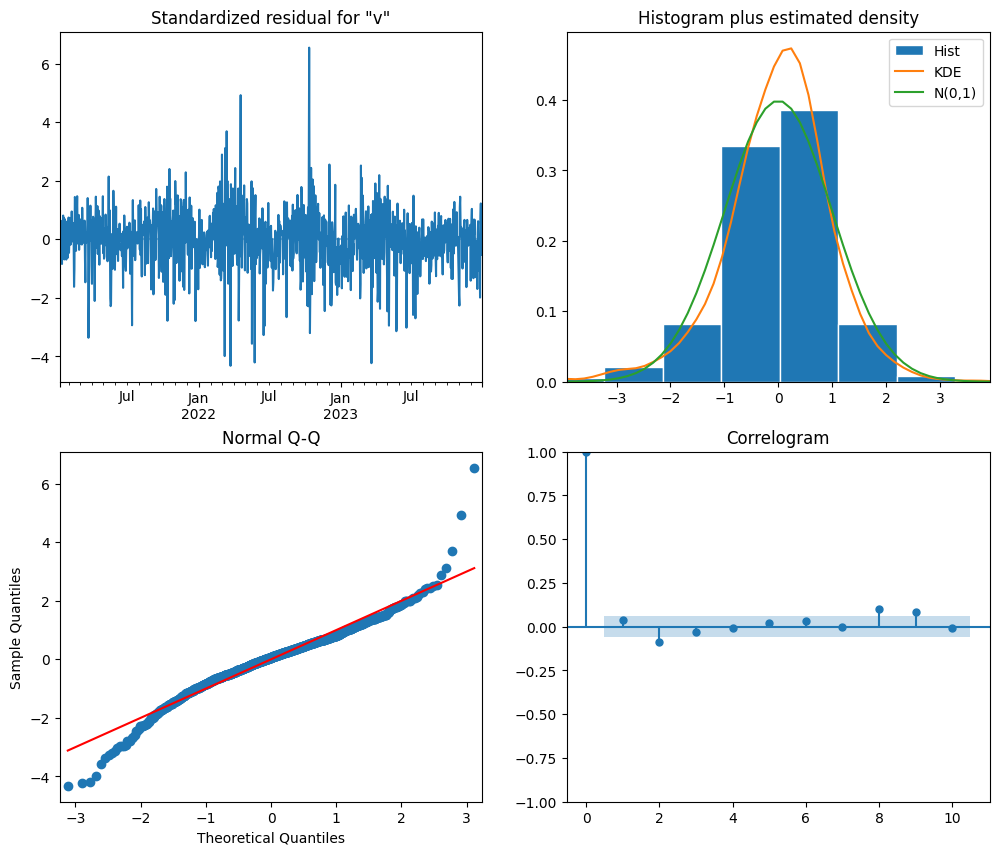

In [69]:
fig_res_med = resA_med.plot_diagnostics(figsize=(12,10))

* **Ljung-Box:** los residuos no exhiben correlación serial ($p=0.22$).
    * Se cumple el supuesto de incorrelación de los residuos.
* **Jarque-Bera:** los residuos no siguen una distibución Normal ($p<0.01$).
    * No se cumple el supuesto de Normalidad de los residuos.
* **Heterocedasticidad:** los residuos tienen varianza estable en el tiempo ($p = 0.75$).
    * Se cumple el supuesto de homocedasticidad.

### 4.c. Fac. de Ingeniería

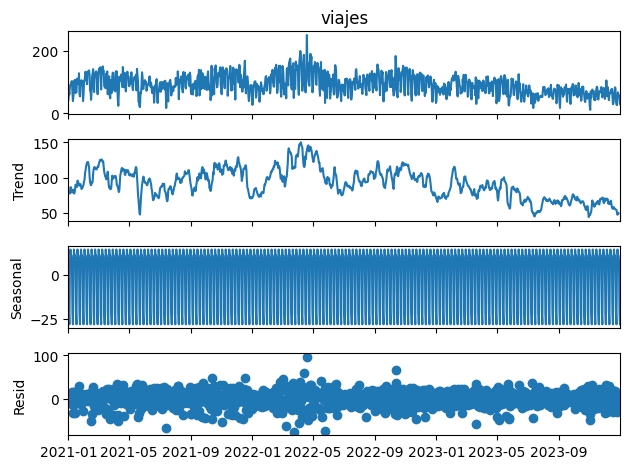

In [50]:
result = seasonal_decompose(ing_train['viajes'])
result.plot();

Se detecta un componente estacional de período 7 (semanal).

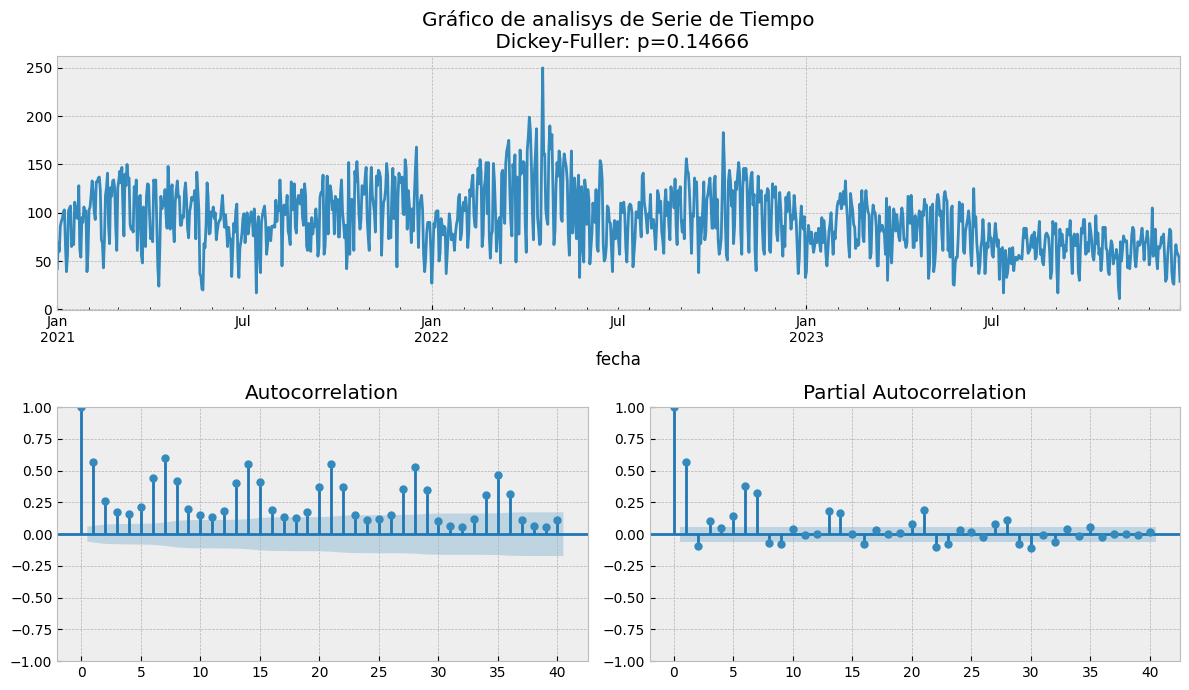

In [51]:
tsplot(ing_train['viajes'], lags = 40);

El test de raíces unitarias arroja un p-value elevado, por lo que habría que diferenciar la serie para transformarla en estacionaria.

Al igual que con la serie anterior, se podría probar con una diferenciación regular y una estacional.

In [104]:
ing_diff = ing_train.viajes.values[1:] - ing_train.viajes.values[:-1]
ing_diff = np.concatenate([ing_diff, [0]])
ing_train['viajes_diff'] = ing_diff

C:\Users\PC\AppData\Local\Temp\ipykernel_18256\4204820684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_train['viajes_diff'] = ing_diff


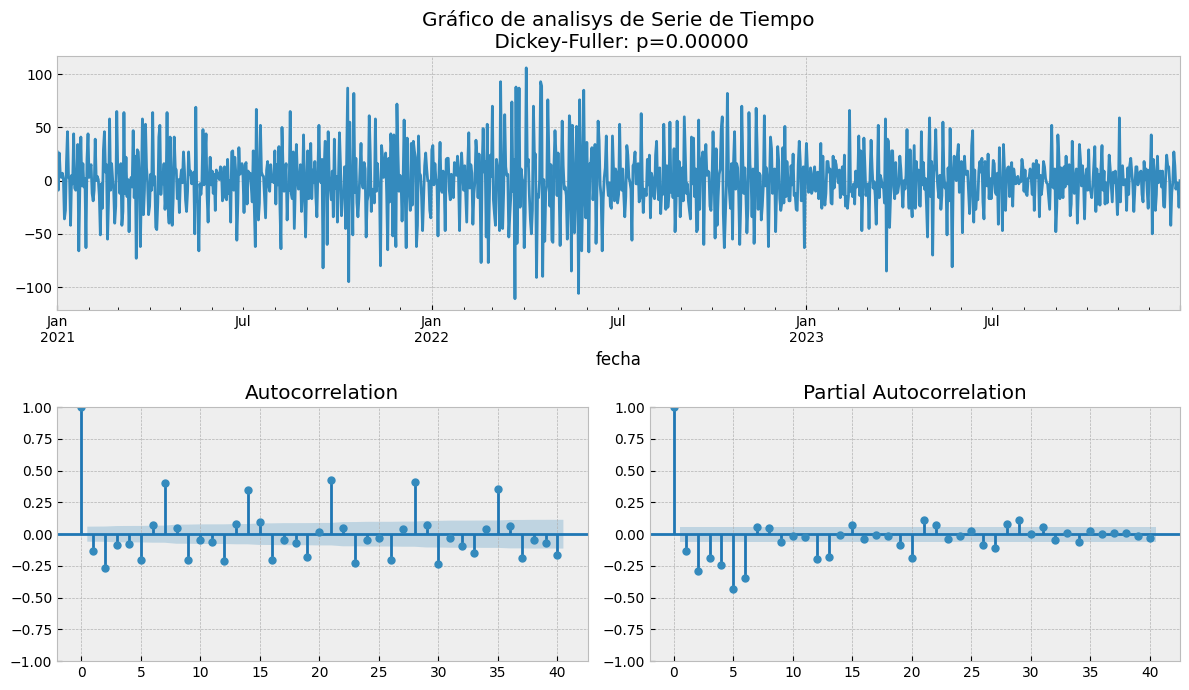

In [105]:
tsplot(ing_train['viajes_diff'], lags = 40);

Si bien el test de raíces unitarias ya no señala una necesidad de diferenciar, la FAC muestra que los lags $7k$ no decrecen.

Podría considerarse, entonces, aplicar una diferenciación estacional en lugar de una regular.

In [106]:
ingD1 = ing_train.viajes.values[7:] - ing_train.viajes.values[:-7]
ingD1 = np.concatenate([ingD1, 7*[0]])
ing_train['viajes_D1'] = ingD1

C:\Users\PC\AppData\Local\Temp\ipykernel_18256\1244774242.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_train['viajes_D1'] = ingD1


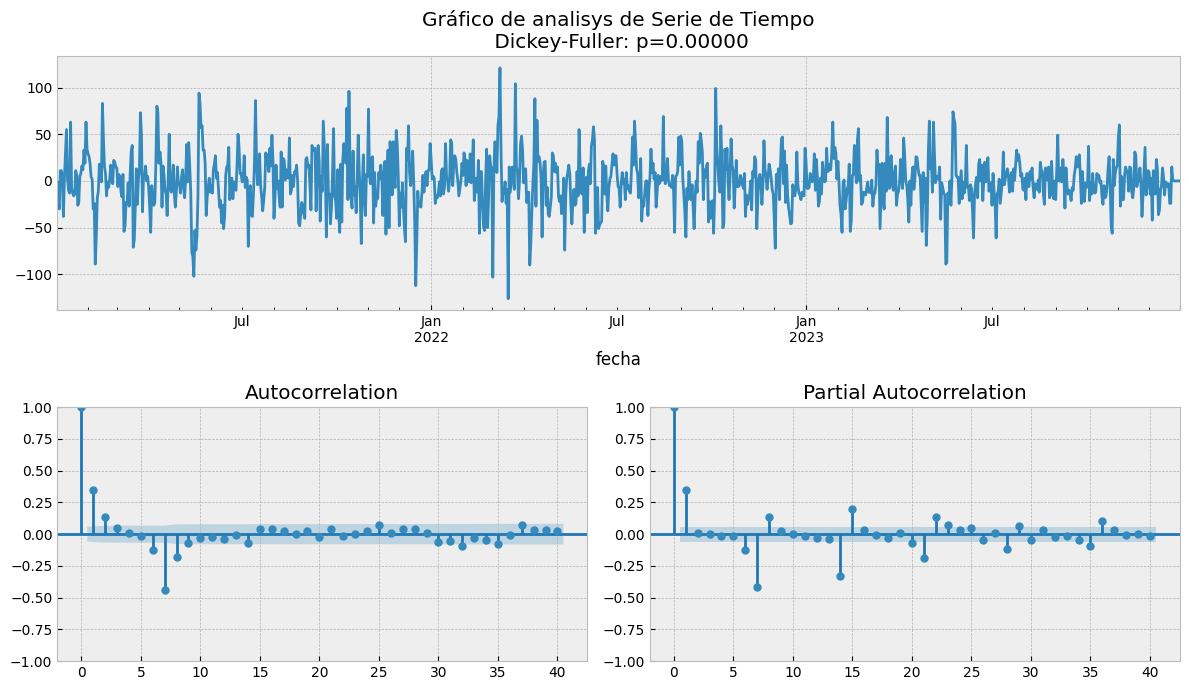

In [55]:
tsplot(ing_train['viajes_D1'], lags = 40);

Una vez más, ahora el test de raíces unitarias indica estacionariedad, y la FAC parece mostrar una convergencia de las correlaciones.

La FAC y la FACP se muestran muy similares a las series anteriores, por lo que podrían trazarse las mismas conclusiones.

Visto que la diferenciación estacional es estrictamente necesaria para esta serie, se propondrán sólo dos modelos:

* **Modelo A:** simple y con diferenciación estacional
* **Modelo B:** complejo y con diferenciación estacional

#### Modelo A: simple y con diferenciación estacional

In [57]:
model_ing = auto_arima(
    ing_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=1,
    max_p=2, max_q=2,
    max_P=2, max_Q=2,
    test='adf', with_intercept=False,
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7]             : AIC=9929.004, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=10355.030, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=9975.291, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=9750.228, Time=0.12 sec
 ARIMA(0,0,1)(0,1,0)[7]             : AIC=10230.461, Time=0.05 sec
 ARIMA(0,0,1)(1,1,1)[7]             : AIC=9743.728, Time=0.20 sec
 ARIMA(0,0,1)(1,1,0)[7]             : AIC=9996.492, Time=0.08 sec
 ARIMA(0,0,1)(2,1,1)[7]             : AIC=9745.493, Time=0.58 sec
 ARIMA(0,0,1)(1,1,2)[7]             : AIC=9745.351, Time=0.63 sec
 ARIMA(0,0,1)(0,1,2)[7]             : AIC=9743.842, Time=0.40 sec
 ARIMA(0,0,1)(2,1,0)[7]             : AIC=9847.701, Time=0.18 sec
 ARIMA(0,0,1)(2,1,2)[7]             : AIC=9747.042, Time=1.18 sec
 ARIMA(1,0,1)(1,1,1)[7]             : AIC=9678.595, Time=0.50 sec
 ARIMA(1,0,1)(0,1,1)[7]             : AIC=9681.600, Time=0.25 sec
 ARIMA(1,0,1)(1,1,0)[7]        

In [71]:
modA_ing = SARIMAX(ing_train['viajes'], order=(1, 0, 1), seasonal_order=(0, 1, 2, 7))
resA_ing = modA_ing.fit()
predA_ing = resA_ing.get_forecast(steps=121)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [72]:
print("Métricas de performance del pronóstico")
print("AIC: ", round(resA_ing.aic, 1))
print("------------")
evaluar_metricas(ing_test['viajes'], predA_ing.predicted_mean)

Métricas de performance del pronóstico
AIC:  9678.3
------------
MSE:  314.86
MAE:  13.73
RMSE: 17.74
MAPE: 0.4631


En su capacidad predictiva, el modelo A presenta un error absoluto medio de 14 viajes.

Los pronósticos difieren en un 46% de los valores observados.

#### Modelo B: complejo y con diferenciación estacional

In [60]:
model_ing = auto_arima(
    ing_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=1,
    max_p=7, max_q=7,
    max_P=7, max_Q=7,
    test='adf', with_intercept=False,
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7]             : AIC=9929.004, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=10355.030, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=9975.291, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=9750.228, Time=0.11 sec
 ARIMA(0,0,1)(0,1,0)[7]             : AIC=10230.461, Time=0.05 sec
 ARIMA(0,0,1)(1,1,1)[7]             : AIC=9743.728, Time=0.20 sec
 ARIMA(0,0,1)(1,1,0)[7]             : AIC=9996.492, Time=0.09 sec
 ARIMA(0,0,1)(2,1,1)[7]             : AIC=9745.493, Time=0.60 sec
 ARIMA(0,0,1)(1,1,2)[7]             : AIC=9745.351, Time=0.66 sec
 ARIMA(0,0,1)(0,1,2)[7]             : AIC=9743.842, Time=0.40 sec
 ARIMA(0,0,1)(2,1,0)[7]             : AIC=9847.701, Time=0.19 sec
 ARIMA(0,0,1)(2,1,2)[7]             : AIC=9747.042, Time=1.25 sec
 ARIMA(1,0,1)(1,1,1)[7]             : AIC=9678.595, Time=0.54 sec
 ARIMA(1,0,1)(0,1,1)[7]             : AIC=9681.600, Time=0.27 sec
 ARIMA(1,0,1)(1,1,0)[7]        

El modelo B es igual al modelo A.

In [64]:
pronosticos_simples(ing_train, ing_test)

             MSE    MAE   RMSE    MAPE
avg      1614.02  35.89  40.17  1.1026
drift    1192.26  30.35  34.53  0.5536
naive    1072.17  28.52  32.74  0.5340
naive_s   438.00  16.02  20.93  0.4011


C:\Users\PC\AppData\Local\Temp\ipykernel_18256\3463645638.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts['naive'] = len(test)*[train['viajes'][-1]]


El naive estacional arroja un menor valor MAPE que el modelo seleccionado, pero no lo supera en las demás métricas.

#### Pronóstico del modelo seleccionado

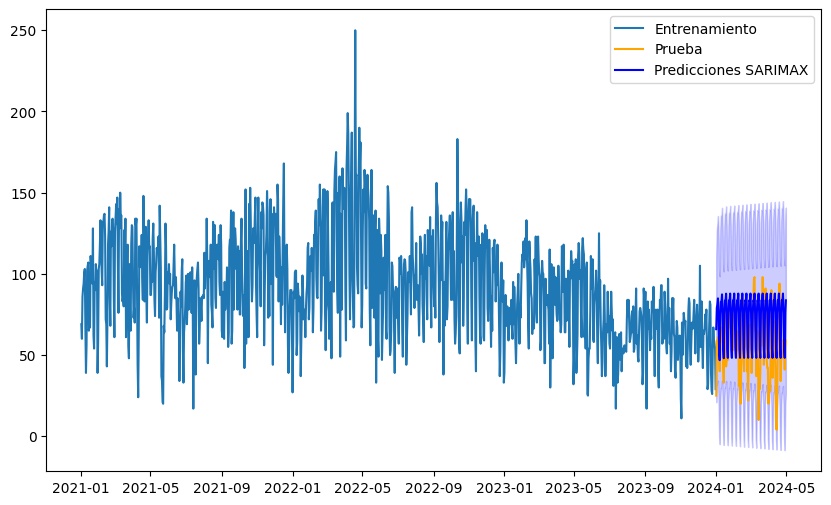

In [67]:
# Predicciones del modelo
pred_ing = resA_ing.get_forecast(steps=121)
pred_ci_ing = predA_ing.conf_int()


plt.figure(figsize=(10, 6))
plt.plot(ing_train.index, ing_train['viajes'], label='Entrenamiento')
plt.plot(ing_test.index, ing_test['viajes'], label='Prueba', color='orange')
plt.plot(ing_test.index, pred_ing.predicted_mean, label='Predicciones SARIMAX', color='blue')
plt.fill_between(ing_test.index, pred_ci_ing.iloc[:, 0], pred_ci_ing.iloc[:, 1], color='blue', alpha=0.2)
plt.legend()
plt.show()

In [73]:
resA_ing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                 viajes   No. Observations:                 1094
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -4834.162
Date:                                Wed, 25 Dec 2024   AIC                           9678.325
Time:                                        13:05:14   BIC                           9703.281
Sample:                                    01-02-2021   HQIC                          9687.771
                                         - 12-31-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6421      0.047     13.533      0.000       0.549       0.735
ma.L1         -0.2201      0.055     -3.984      0.000      -0.328      -0.112
ma.S.L7       -0.8256      0.025    -32.790      0.000      -0.875      -0.776
ma.S.L14      -0.0752      0.027     -2.832      0.005      -0.127      -0.023
sigma2       422.4554     12.793     33.024      0.000     397.383     447.528
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               234.43
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

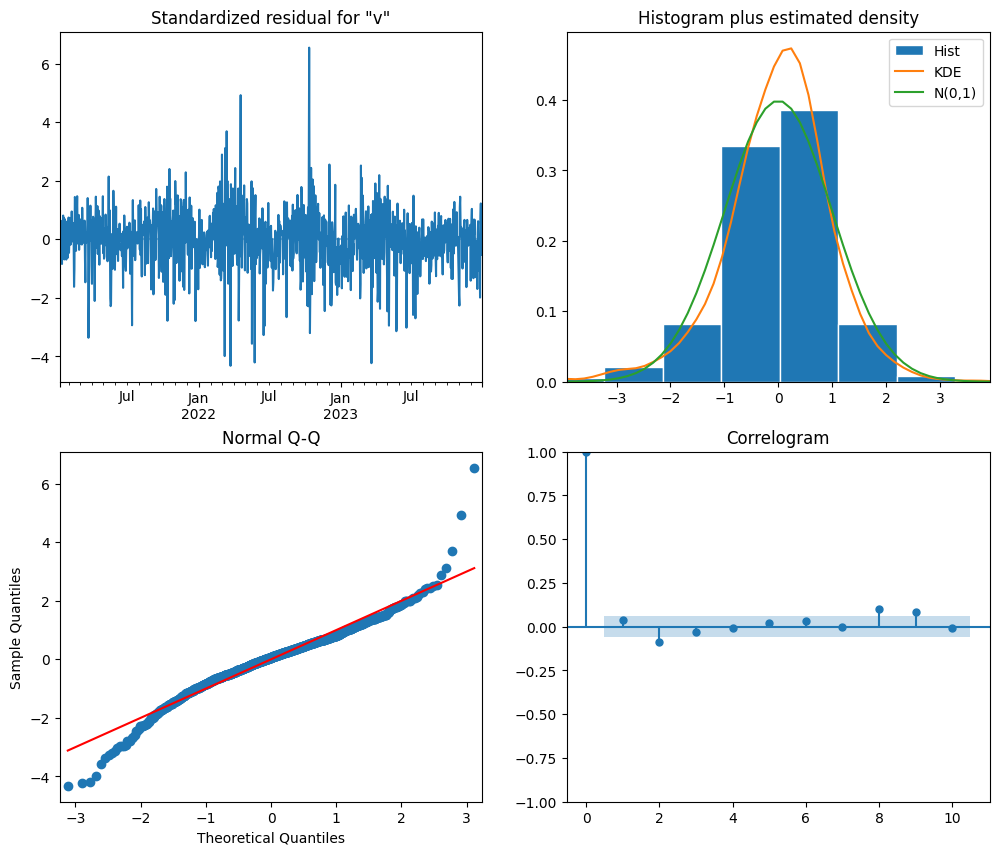

In [70]:
fig_res_med = resA_ing.plot_diagnostics(figsize=(12,10))

* **Ljung-Box:** los residuos no exhiben correlación serial ($p=0.77$).
    * Se cumple el supuesto de incorrelación de los residuos.
* **Jarque-Bera:** los residuos no siguen una distibución Normal ($p<0.01$).
    * No se cumple el supuesto de Normalidad de los residuos.
* **Heterocedasticidad:** los residuos tienen varianza variable en el tiempo ($p < 0.01$).
    * No se cumple el supuesto de homocedasticidad.

## 5. Modelo VAR

In [110]:
eco_train_var = eco_train.drop(['destino', 'viajes'], axis=1)
eco_train_var = eco_train_var.rename(columns={"viajes_D1": "eco"})

med_train_var = med_train.drop(['destino', 'viajes', 'viajes_diff'], axis=1)
med_train_var = med_train_var.rename(columns={"viajes_D1": "med"})

ing_train_var = ing_train.drop(['destino', 'viajes', 'viajes_diff'], axis=1)
ing_train_var = ing_train_var.rename(columns={"viajes_D1": "ing"})

serieVAR = pd.concat([eco_train_var, med_train_var, ing_train_var], axis=1)

In [111]:
serieVAR

,eco,med,ing
fecha,,,
2021-01-01,60,47,61
2021-01-02,15,18,-2
2021-01-03,3,-9,-21
2021-01-04,-39,-19,-30
2021-01-05,-6,11,11
...,...,...,...
2023-12-27,0,0,0
2023-12-28,0,0,0
2023-12-29,0,0,0
